Importer les librairies

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import date, timedelta

Importation des actions

In [38]:
today = date.today()
five_years_ago = today.replace(year=today.year - 5)
symbols = [
    "AC.PA", "AI.PA", "AIR.PA", "ALO.PA", "BN.PA", "BNP.PA", "CA.PA", "CAP.PA", "CS.PA", "DG.PA",
    "DSY.PA", "EL.PA", "ENGI.PA", "ENX.PA", "FP.PA", "GLE.PA", "HO.PA", "KER.PA", "LR.PA", "MC.PA",
    "ML.PA", "OR.PA", "ORA.PA", "PUB.PA", "RMS.PA", "SAF.PA", "SAN.PA", "SGO.PA", "SU.PA", "SW.PA",
    "SY.PA", "UG.PA", "UL.PA", "VIE.PA", "VIV.PA"
] #Action du CAC40 qui sont dedans depuis plus de 5 ans

valid_symbols = [] #Action a garder après vérification

#Vérification des valeurs de fermeture pour chaque action, on vérifie qu'il y a bien 5 ans de données
for symbol in symbols:
    data = yf.download(symbol, start=five_years_ago, end=today)["Close"]
    # Si l'action a au moins 5 ans de données, on la garde
    if len(data.dropna()) > 0:
        valid_symbols.append(symbol)


data = yf.download(valid_symbols, start=five_years_ago, end=today)["Close"] #Jeu de données utiliser pour la suite du projet qui représente la valeur de chaque action par jour après la fermeture de la bourse

C:\Users\metier\AppData\Local\Temp\ipykernel_14672\1677395284.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=five_years_ago, end=today)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\metier\AppData\Local\Temp\ipykernel_14672\1677395284.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=five_years_ago, end=today)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\metier\AppData\Local\Temp\ipykernel_14672\1677395284.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=five_years_ago, end=today)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\metier\AppData\Local\Temp\ipykernel_14672\1677395284.py:14: FutureWarning: YF.download() has changed argument auto_adjust default 

Calcule du rendement par action

In [39]:
daily_rendement = data.pct_change()  #Calcul du rendement journalier grâce à pct_change() qui utilise la formule suivante (valeur_actuelle - valeur_précédente)/valeur_précédente
daily_rendement = daily_rendement.fillna(0) #Remplace les valeurs NaN par 0 pour ne pas avoir de problèmes dans les calculs suivant
# Conversion des rendements journaliers en rendements mensuels composés (produit des facteurs sur chaque mois)
#On transforme les rendements en facteurs multiplicatifs puis avec resample('ME') on regroupe les données par mois, finalement on fait le produit de tous les rendements du mois
month_rendement = (1+daily_rendement).resample('ME').prod()-1

C:\Users\metier\AppData\Local\Temp\ipykernel_14672\2555015399.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_rendement = data.pct_change()  #Calcul du rendement journalier grâce à pct_change() qui utilise la formule suivante (valeur_actuelle - valeur_précédente)/valeur_précédente


Moyenne des rendements/matrices de covariance et de corrélation

Ticker      AC.PA     AI.PA    AIR.PA    ALO.PA     BN.PA    BNP.PA     CA.PA  \
Ticker                                                                          
AC.PA    0.098365  0.019904  0.061010  0.050593  0.022164  0.070474  0.024451   
AI.PA    0.019904  0.032018  0.023752  0.029110  0.013590  0.021835  0.020853   
AIR.PA   0.061010  0.023752  0.093991  0.052301  0.021467  0.073298  0.023910   
ALO.PA   0.050593  0.029110  0.052301  0.176737  0.010978  0.081234  0.021421   
BN.PA    0.022164  0.013590  0.021467  0.010978  0.029428  0.018353  0.015062   
BNP.PA   0.070474  0.021835  0.073298  0.081234  0.018353  0.120778  0.020918   
CA.PA    0.024451  0.020853  0.023910  0.021421  0.015062  0.020918  0.041412   
CAP.PA   0.034851  0.024401  0.033423  0.005320  0.010226  0.027759  0.015166   
CS.PA    0.054408  0.023608  0.055900  0.048871  0.020202  0.075210  0.021782   
DG.PA    0.045697  0.021199  0.051679  0.038174  0.021925  0.055885  0.023289   
DSY.PA   0.004929  0.015010 

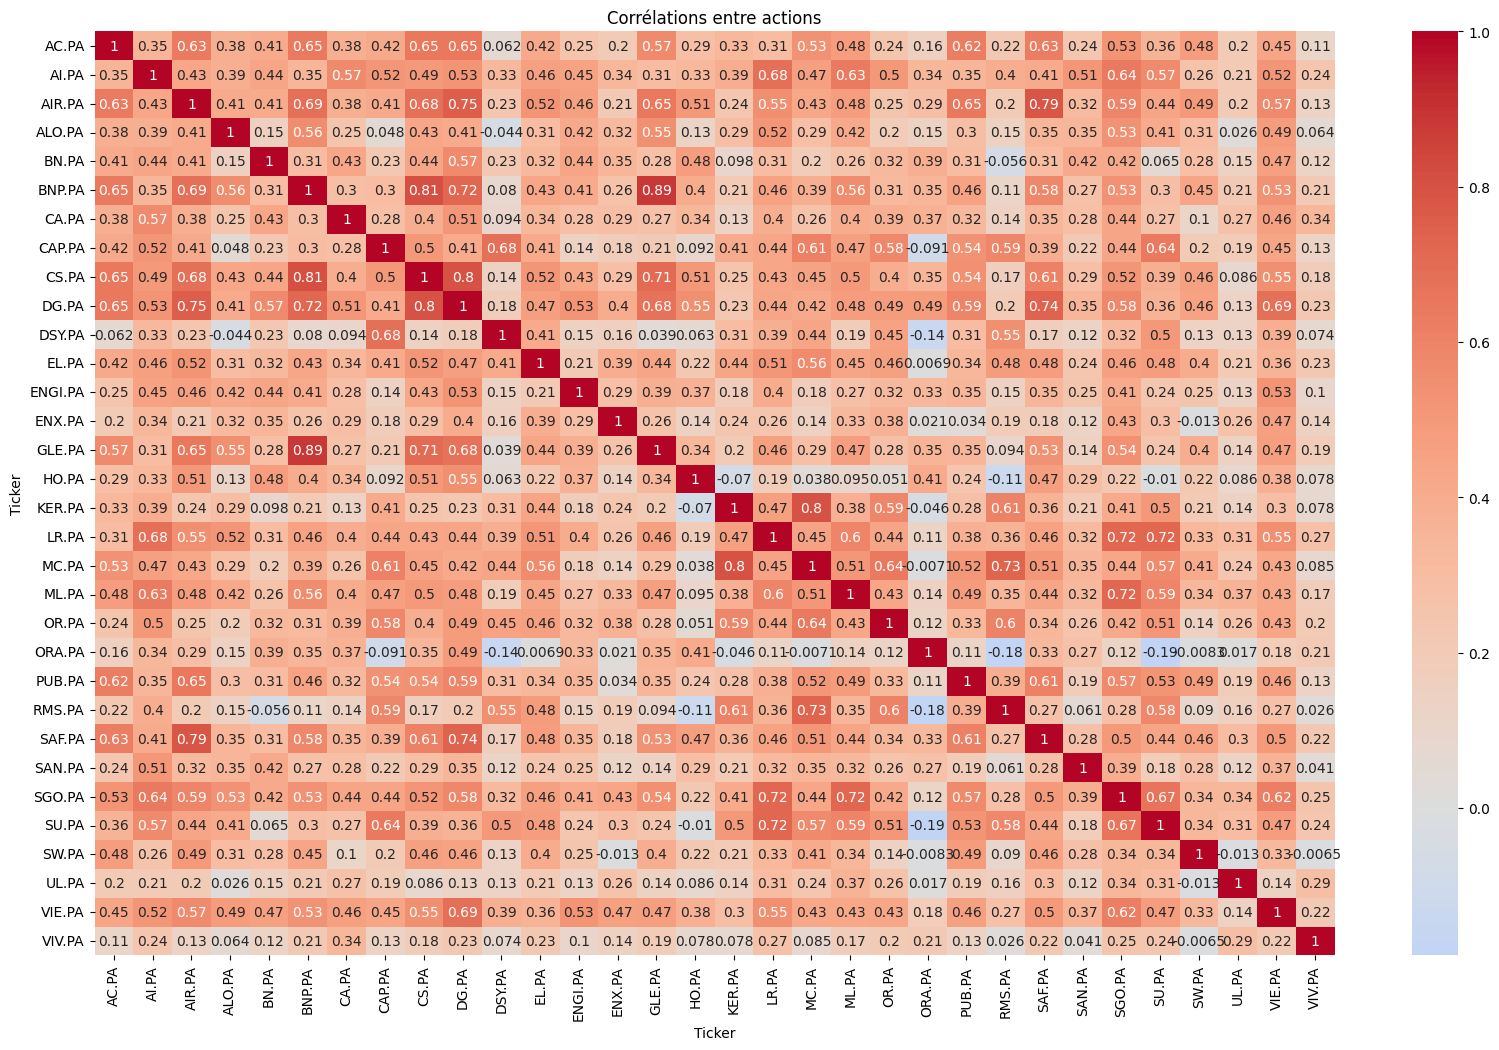

In [40]:
# Annualisation des statistiques car en général on regarde le rendement annuel
annual_returns = month_rendement.mean() * 12
covariance_matrix  = month_rendement.cov() * 12
mean_returns = annual_returns.values  # Utile pour les fonctions d'optimisation car sous forme de liste
correlation_matrix = month_rendement.corr() #Corrélation indépendante du temps pas besoin de multiplier par 12
print(covariance_matrix)
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations entre actions")
plt.show()

Histogramme

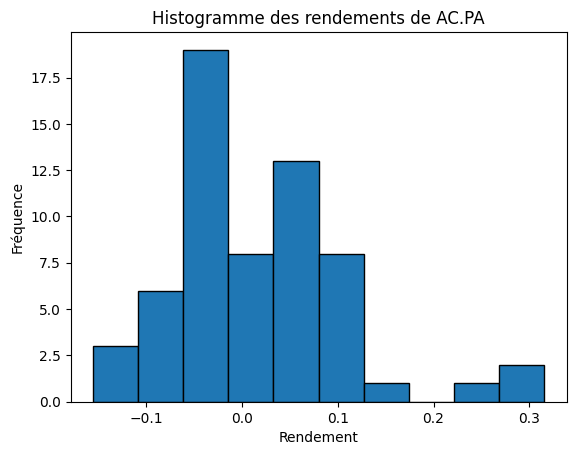

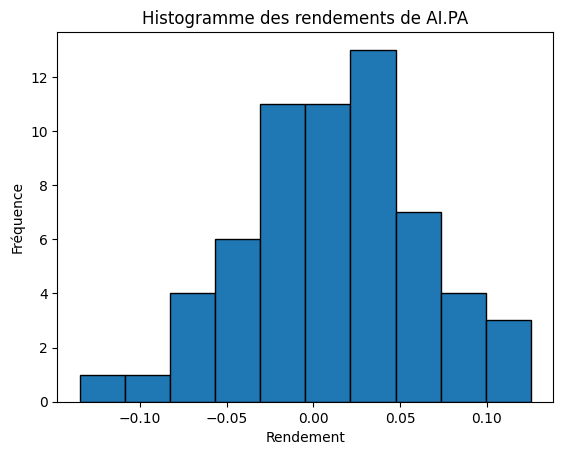

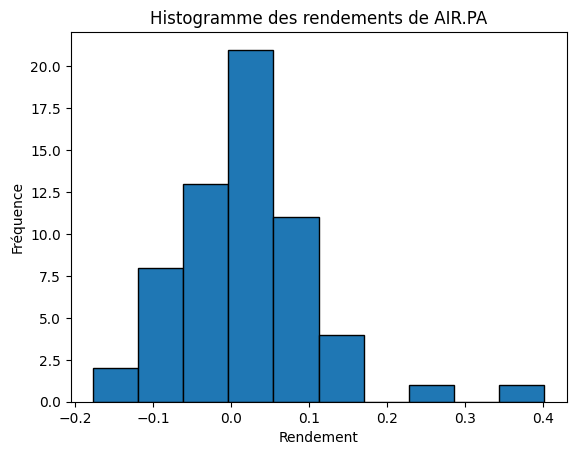

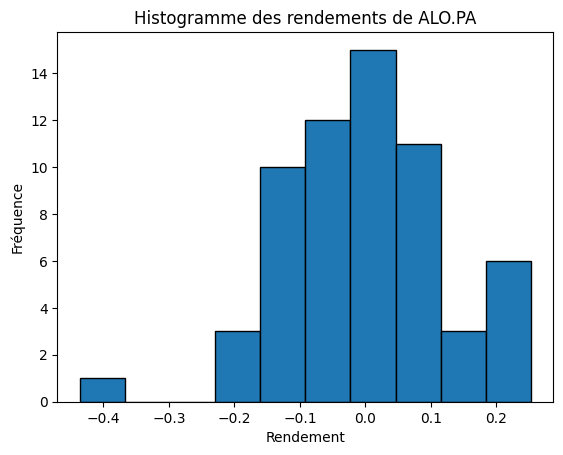

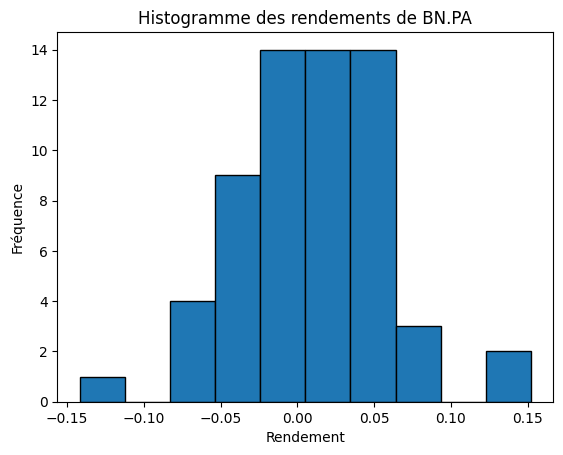

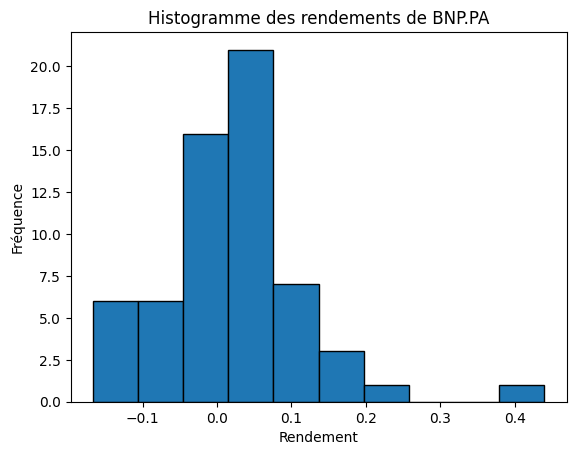

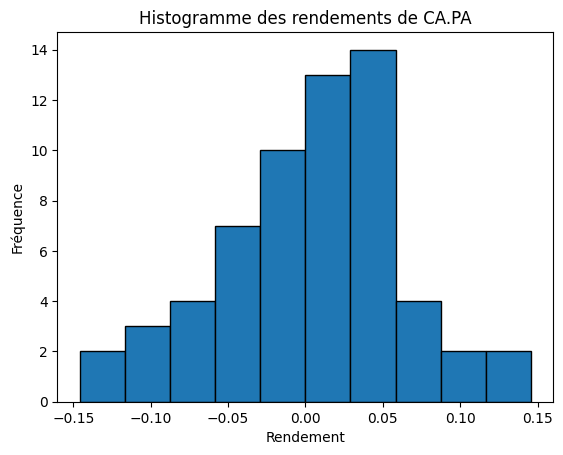

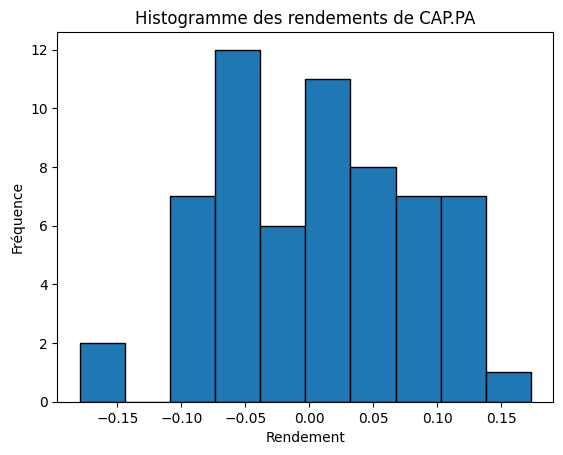

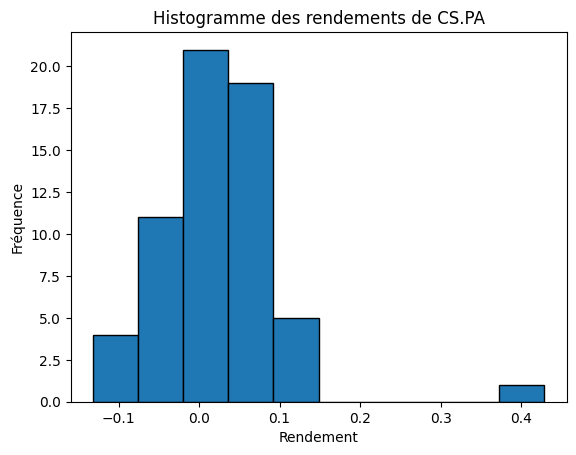

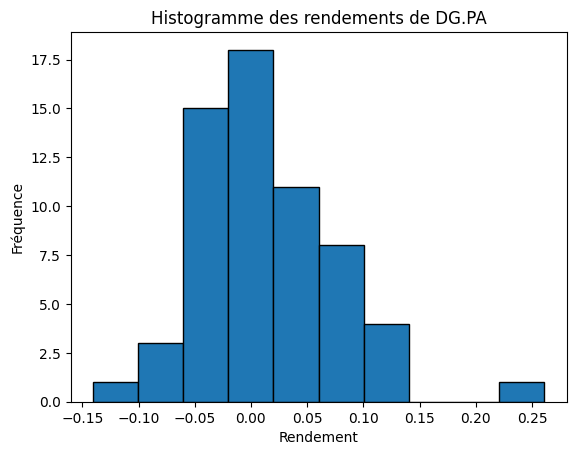

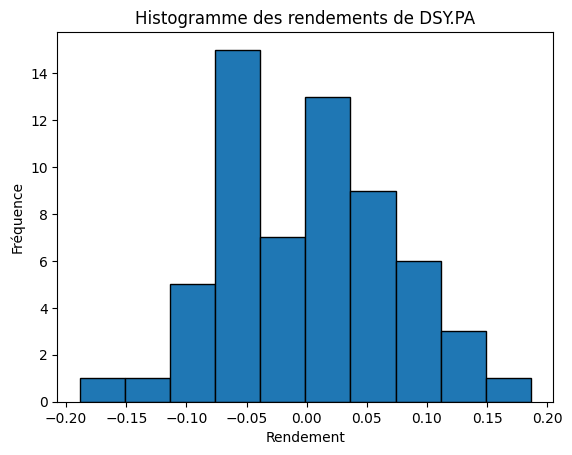

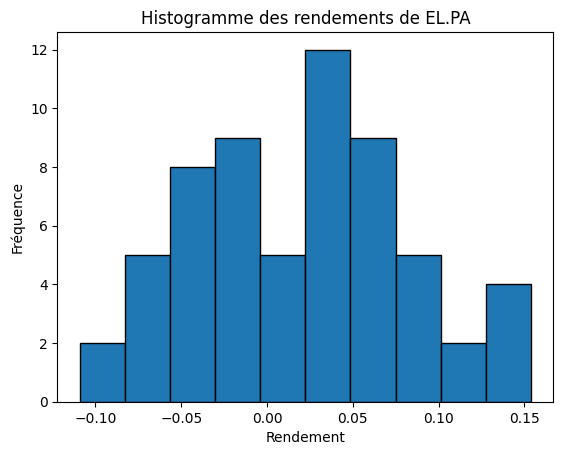

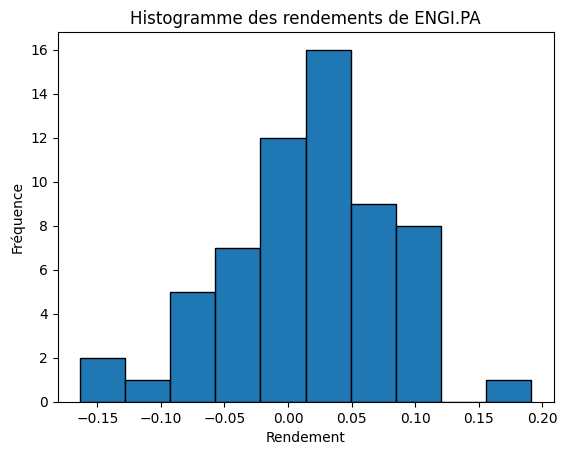

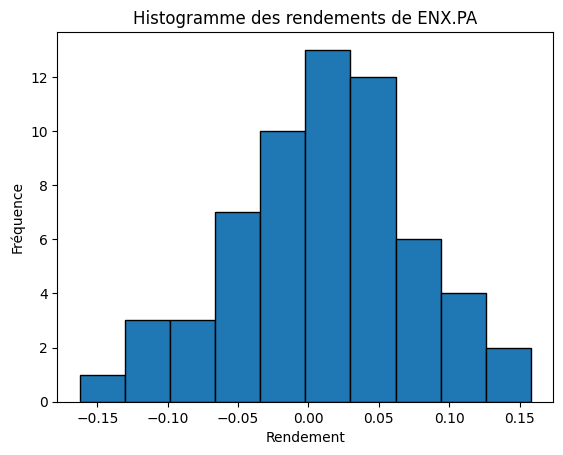

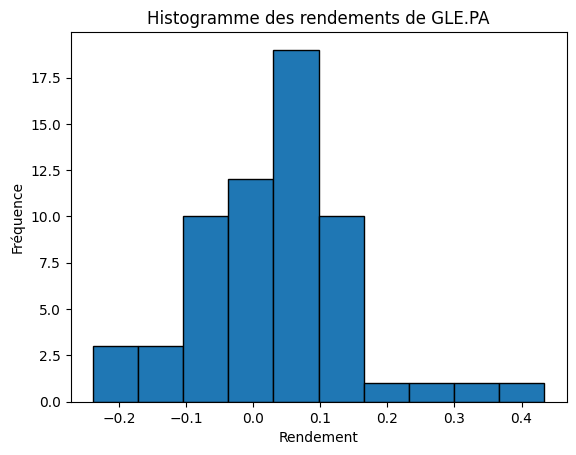

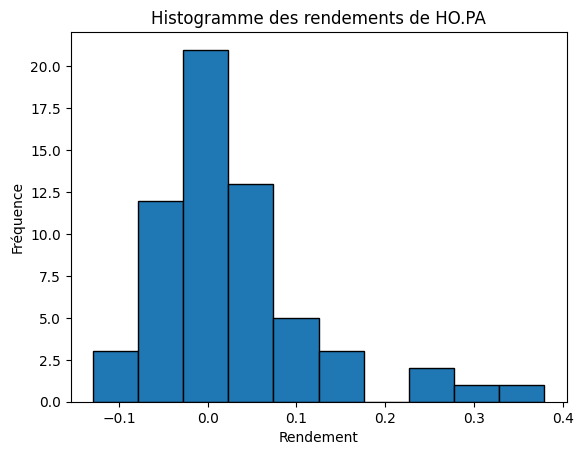

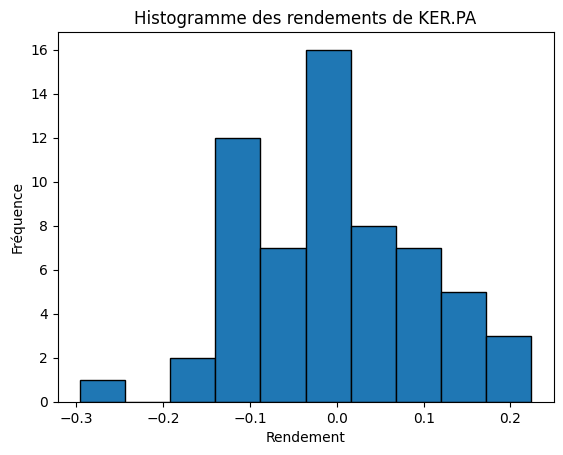

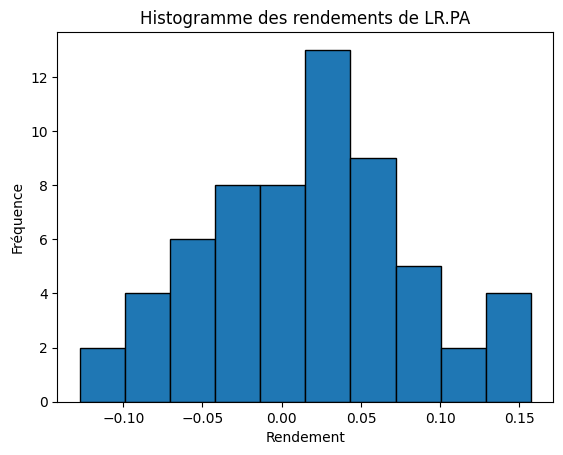

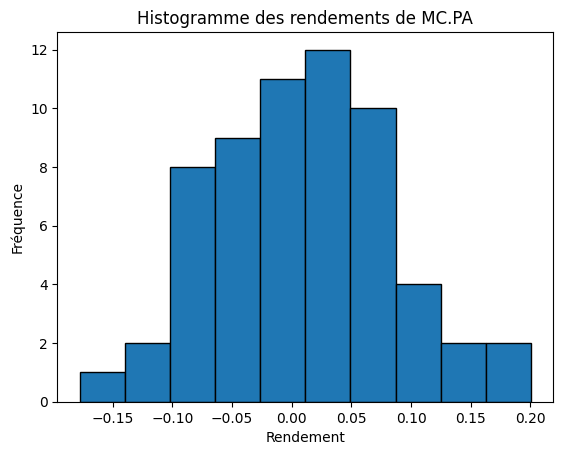

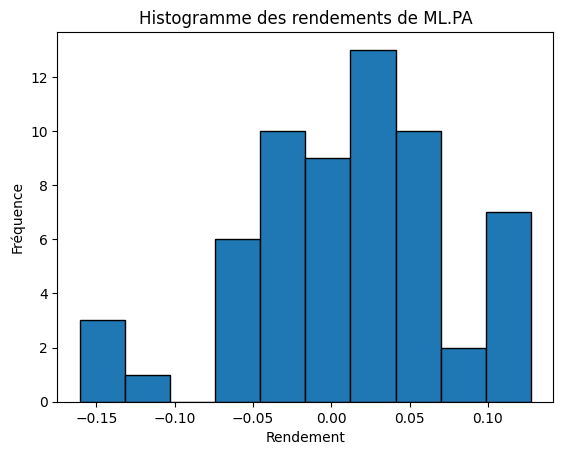

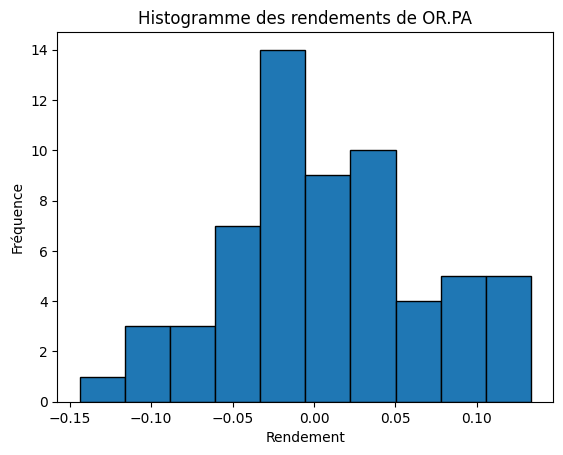

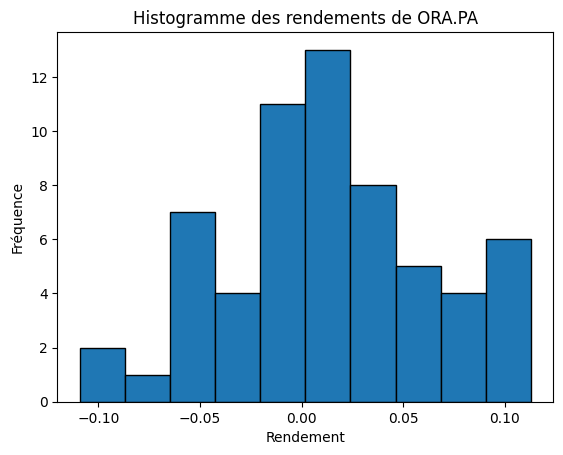

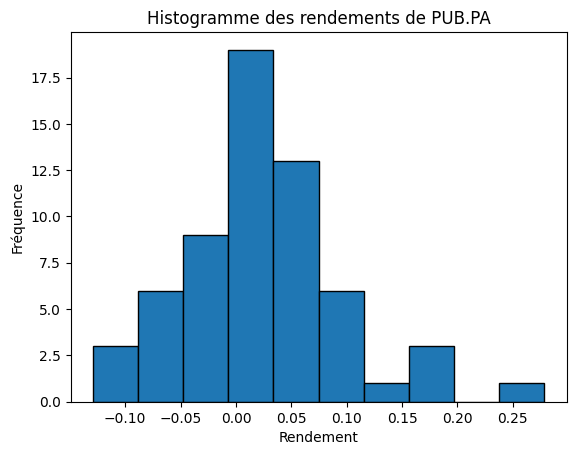

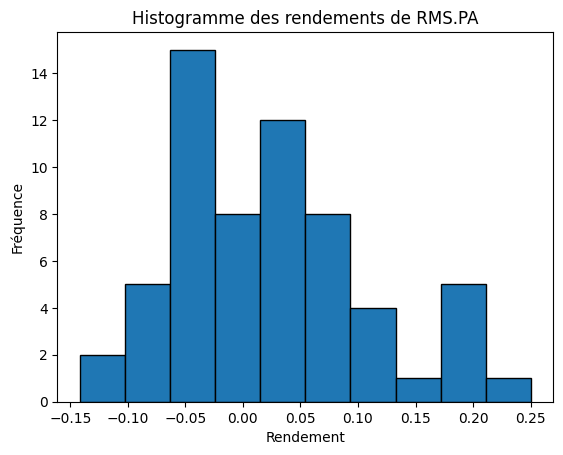

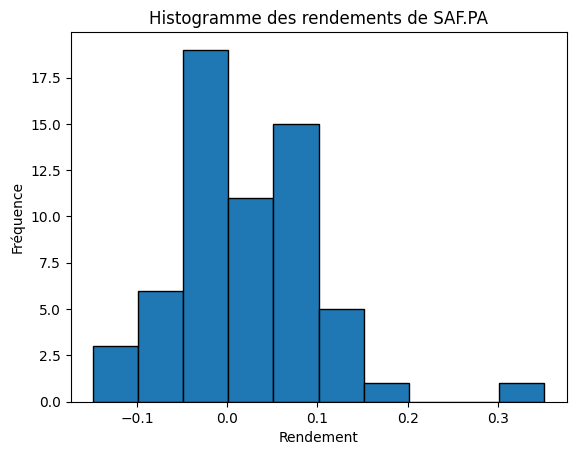

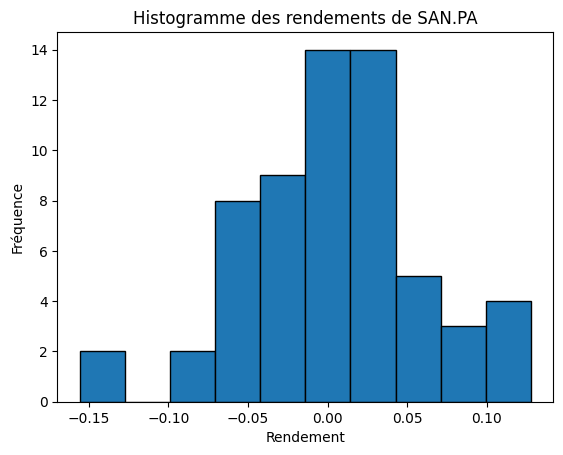

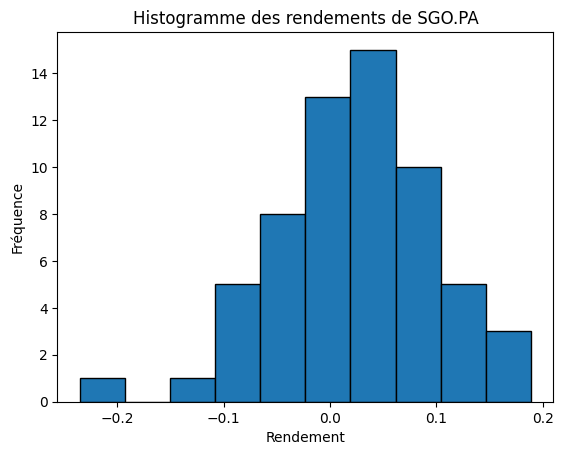

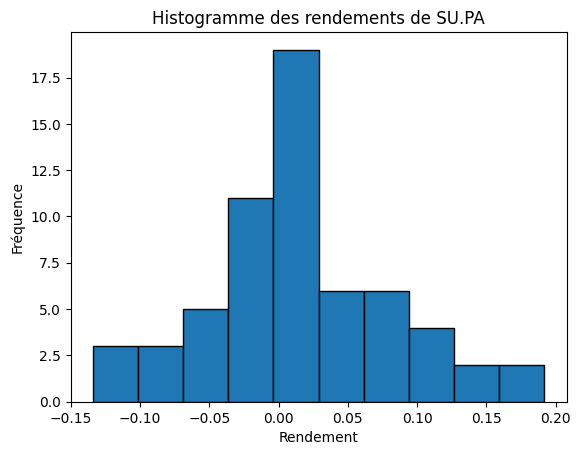

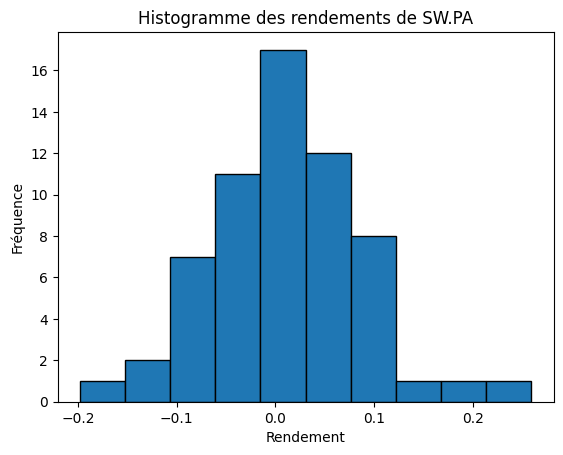

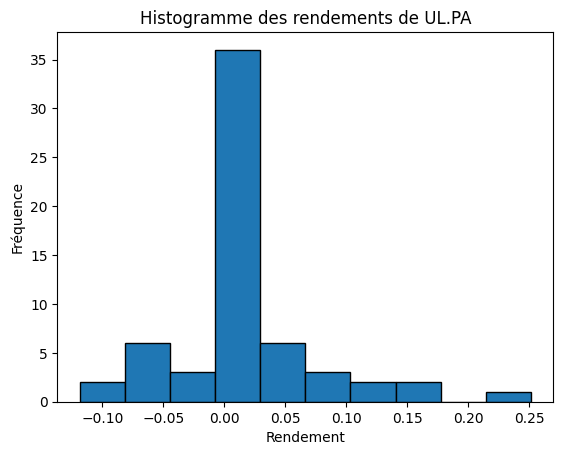

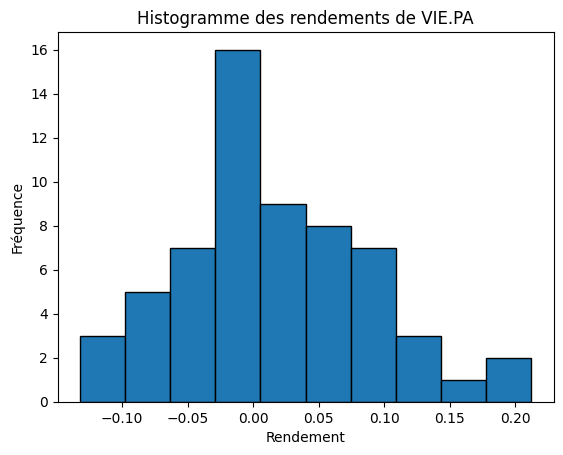

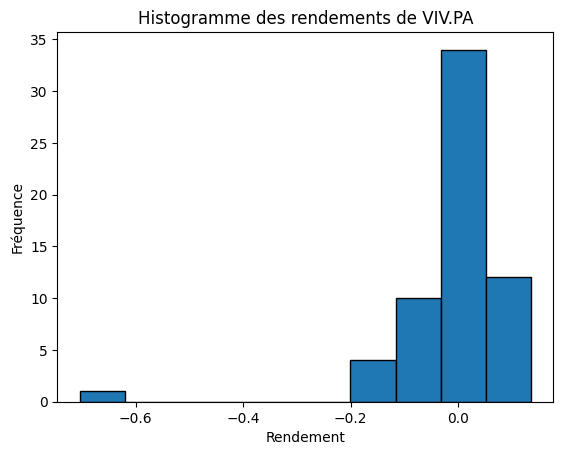

In [41]:
for action in valid_symbols:
    plt.hist(month_rendement[action], edgecolor='black')
    plt.title("Histogramme des rendements de " + action)
    plt.xlabel("Rendement")
    plt.ylabel("Fréquence")
    plt.show()


Optimisation, recherche du portefeuille avec le plus faible risque

In [42]:
#Le risque est la variance du rendement
#On veut minimiser le risque 
def variance_wallet(poids,matrice_cov):
    return  np.sqrt(np.transpose(poids) @ matrice_cov @ poids) #Formule matricielle de la variance d'un portefeuille

bounds = [(0,1) for j in range(len(valid_symbols))] #Pas de vente à découvert
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w)-1} #Le poids total du portefeuille ne peut être différent de 100% car on veut un portefeuille complet
optimisation = minimize(variance_wallet,[1/len(valid_symbols) for j in range(len(valid_symbols))], args=(covariance_matrix,),method='SLSQP',bounds=bounds, constraints=constraints).x
print(optimisation)
print(sum(optimisation))



[0.00000000e+00 1.78536823e-17 0.00000000e+00 2.47825333e-18
 3.49842447e-02 8.81639634e-18 4.71449080e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.66659849e-02 5.53796686e-18
 9.36206531e-18 1.29077322e-01 2.79915455e-17 3.43465453e-17
 1.00248673e-17 0.00000000e+00 0.00000000e+00 7.50621025e-18
 9.33183639e-18 3.28593743e-01 5.46597942e-18 6.71934132e-02
 8.60535051e-18 7.20782989e-02 0.00000000e+00 9.45896493e-03
 1.11693934e-01 1.60254095e-01 0.00000000e+00 0.00000000e+00]
1.0000000000000004


Optimisation par ratio de Sharpe 

In [43]:
# Trouver le portefeuille le plus équilibré en terme de risque/rendement plus le ratio de Sharpe est grand mieux c'est
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free=0.0): # Ratio de Sharpe = (Rendement du portefeuille - Taux sans risque) / Volatilité du portefeuille
    port_rendement = np.dot(weights, mean_returns)
    port_volatilite = np.sqrt(np.transpose(weights) @ cov_matrix.values @ weights)
    # éviter division par zéro
    if port_volatilite == 0:
        return 1e6
    return - (port_rendement - risk_free) / port_volatilite #On utilise la formule négative car pour maximiser le ratio ça revient à minimiser le négatif

n = len(valid_symbols)
x0 = np.full(n, 1/n) #Poids de base équiproba
bounds = [(0, 1) for j in range(n)]  #Pas de vente à découvert
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) #Le poids total du portefeuille ne peut être différent de 100% car on veut un portefeuille complet

opt_sharpe = minimize(neg_sharpe_ratio, x0,args=(mean_returns, covariance_matrix,0.02),method='SLSQP', bounds=bounds, constraints=constraints) #On met un taux à 2% pour simuler l'inflation
weights_sharpe = opt_sharpe.x
rendement_sharpe = np.dot(weights_sharpe, mean_returns)
volatilite_sharpe = np.sqrt(np.transpose(weights_sharpe) @ covariance_matrix.values @ weights_sharpe)
sharpe_value = (rendement_sharpe-0.02) / volatilite_sharpe
print('Sharpe optimal :', sharpe_value)
print('Rendement :', rendement_sharpe)
print('Volatilité :', volatilite_sharpe)
pd.DataFrame({'Action': valid_symbols, 'Poids_Sharpe': weights_sharpe})


Sharpe optimal : 1.5762047930488314
Rendement : 0.23405838734085332
Volatilité : 0.1358062025219471


,Action,Poids_Sharpe
0,AC.PA,4.183852e-16
1,AI.PA,1.924766e-16
2,AIR.PA,5.471924e-17
3,ALO.PA,1.009330e-15
4,BN.PA,3.745946e-16
5,BNP.PA,3.636081e-16
6,CA.PA,2.444572e-16
7,CAP.PA,7.047463e-17
8,CS.PA,1.278199e-16
9,DG.PA,5.165690e-16


Frontière efficiente

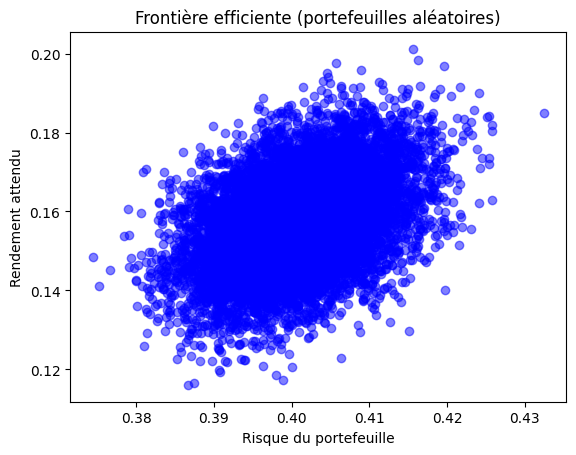

In [44]:
#Nous allons créer 10000 portefeuilles au hasard et les tracer
risque_total = np.zeros(10000)
rendement_total = np.zeros(10000)
for i in range(10000):
    n = len(valid_symbols)  
    weights = np.random.rand(n)      
    weights = weights / np.sum(weights)  # normalise 
    risque = np.sqrt(variance_wallet(weights,covariance_matrix))
    #print(weights)
    rendement = np.transpose(weights) @ mean_returns
    risque_total[i] = risque
    rendement_total[i] = rendement

plt.scatter(risque_total, rendement_total, c='blue', alpha=0.5)
plt.xlabel("Risque du portefeuille")
plt.ylabel("Rendement attendu")
plt.title("Frontière efficiente (portefeuilles aléatoires)")
plt.show()

### Frontière efficiente (optimisée)

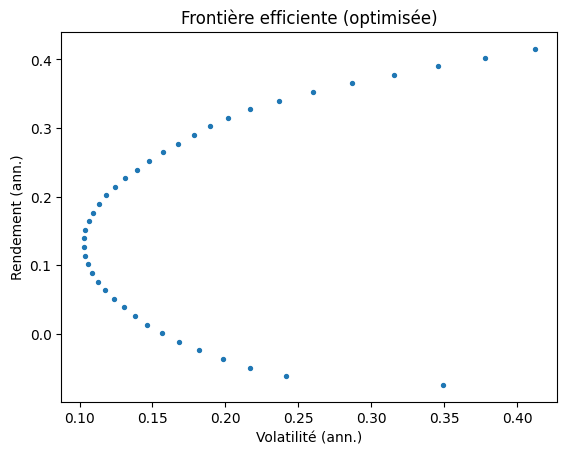

In [45]:
n = len(valid_symbols)
bounds = [(0, 1) for j in range(n)]
constraints_sum = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

target_returns = np.linspace(annual_returns.min(), annual_returns.max(), 40) #On crée 40 rendements possible entre le plus petit et le plus grand trouvé avec nos calculs
frontier_volatiliti = []
frontier_rendement = []
frontier_weights = []


for i in target_returns:
    cons = (constraints_sum,{'type': 'eq', 'fun': lambda w, i=i: np.dot(w, mean_returns) - i}) #Il faut que rendement soit égal à i
    res = minimize(lambda w: variance_wallet(w, covariance_matrix),x0=np.ones(n)/n, bounds=bounds, constraints=cons, method='SLSQP')
    if res.success: #Si on trouve une solution
        w = res.x
        frontier_weights.append(w)
        frontier_rendement.append(np.dot(w, mean_returns))
        frontier_volatiliti.append(variance_wallet(w, covariance_matrix))

plt.figure()
plt.scatter(frontier_volatiliti, frontier_rendement, s=8)
plt.xlabel('Volatilité (ann.)')
plt.ylabel('Rendement (ann.)')
plt.title('Frontière efficiente (optimisée)')
plt.show()


Analyse

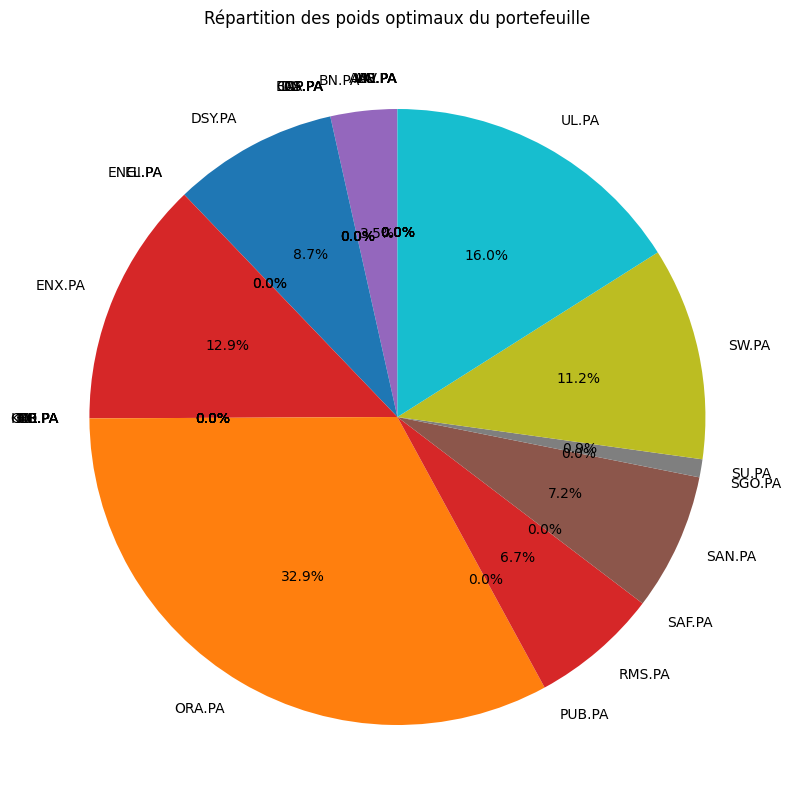

    Action  Poids_Sharpe
21  ORA.PA      0.258532
23  RMS.PA      0.202680
15   HO.PA      0.138917
22  PUB.PA      0.119843
29   UL.PA      0.109784


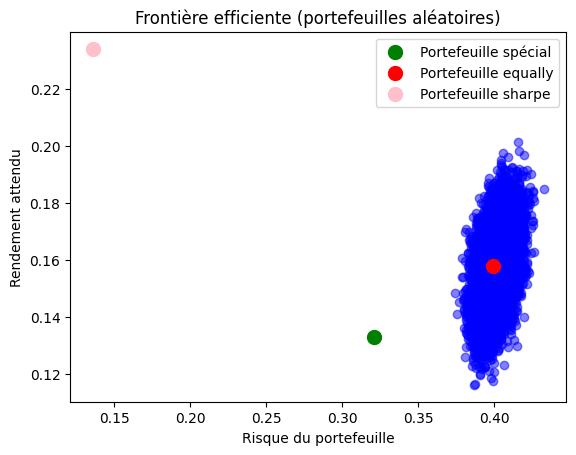

In [46]:
plt.figure(figsize=(10, 10))
plt.pie(optimisation, labels=valid_symbols, autopct="%1.1f%%", startangle=90) #Graphe en camembert de la répartition du portefeuille avec le risque le plus faible
plt.title("Répartition des poids optimaux du portefeuille")
plt.show()

#Action les plus importante pour l'optimisation sharpe
print(pd.DataFrame({'Action': valid_symbols, 'Poids_Sharpe': weights_sharpe}).sort_values(by='Poids_Sharpe', ascending=False).head(5))



#Comparer les portefeuilles
weights = np.array([1/len(valid_symbols) for j in range(len(valid_symbols))])
risque_equally = np.sqrt(variance_wallet(weights,covariance_matrix))
rendement_equally = np.transpose(weights) @ mean_returns

weights = np.array(optimisation)
risque_special = np.sqrt(variance_wallet(weights,covariance_matrix))
rendement_special = np.transpose(weights) @ mean_returns

weights = np.array(opt_sharpe)

plt.scatter(risque_total, rendement_total, c='blue', alpha=0.5)
plt.scatter(risque_special, rendement_special, c='green', s=100, label='Portefeuille spécial')
plt.scatter(risque_equally, rendement_equally, c='red', s=100, label='Portefeuille equally')
plt.scatter(volatilite_sharpe, rendement_sharpe, c='pink', s=100, label='Portefeuille sharpe')
plt.xlabel("Risque du portefeuille")
plt.ylabel("Rendement attendu")
plt.legend()
plt.title("Frontière efficiente (portefeuilles aléatoires)")
plt.show()


### Conclusion

- **Comparaison des portefeuilles :**
  - Le portefeuille **min-variance** minimise le risque global, mais conduit généralement à un rendement plus faible.  
  - Le portefeuille **max-Sharpe** cherche le meilleur compromis rendement/risque. Ici, il offre un ratio de Sharpe nettement supérieur, ce qui le rend plus efficace.

- **Structure des portefeuilles :**
  - En regardant les 5 plus gros poids, on voit que le portefeuille met l’accent sur **Vivendi (VIV.PA)** et **Veolia (VIE.PA)**, suivis par **Unilever (UL.PA)**, **Schneider Electric (SU.PA)** et **Sodexo (SW.PA)**.
  - On remarque donc une combinaison de valeurs **défensives** (Vivendi, Unilever) et de valeurs plus **cycliques/industrielles** (Veolia, Schneider, Sodexo).  
  - S’ils appartiennent à des secteurs **défensifs** (santé, consommation de base, services publics), cela traduit une recherche de stabilité.  
  - À l’inverse, une surpondération de titres **cycliques** (industrie, luxe, technologie) traduit une recherche de rendement plus élevé mais avec davantage de risque.

- **Sensibilité et limites :**
  - Les résultats dépendent fortement de la **période choisie** pour estimer les rendements et covariances.  
  - Les **contraintes imposées** (poids entre 0 et 1, pas de ventes à découvert) influencent aussi fortement la composition optimale.  
  - En pratique, on a le portefeuille ultime d'il y a 5 ans, malheuresement nous ne connaissons pas l'évolution à venir qui peut être totalement différente.

